In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Analysis and modification of training dataset

In [2]:
# Loading training data
train = pd.read_csv('/Users/michalpoleszczuk/Desktop/data_DS_HW_train.csv', sep=';')

In [3]:
train.head()

,application_id,loan_date_created,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,...,informationcount,debtorscount,creditorscount,amount,providerscount,paidobligationscount,averagepaiddebt,averagepaymenttimeindays,sumpaiddebt,TARGET
0,4275,29.11.2020,0,2500,"402,11",0,0,0,0,1,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,1
1,9635,17.02.2021,0,600,0,0,0,0,30,1,...,0.0,0.0,0.0,0,1.0,2.0,1500,1.0,3000,0
2,5383,14.12.2020,0,500,0,0,0,0,0,1,...,0.0,0.0,0.0,0,2.0,3.0,"466,67",0.0,1400,0
3,442,05.10.2020,0,500,0,"0,01",0,0,0,2,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0
4,5070,10.12.2020,0,300,0,0,0,0,0,1,...,0.0,0.0,0.0,0,2.0,18.0,"459,15",0.0,"8264,71",0


In [4]:
# Do we have mising values in target variable?
one=train['TARGET']
one[one.isnull()==True].head()

Series([], Name: TARGET, dtype: int64)

In [5]:
# Checking for missing values
train.isnull().sum()

application_id               0
loan_date_created            0
activeloan_coalt             0
applicationamount            0
applicationprice             0
                            ..
paidobligationscount        43
averagepaiddebt             43
averagepaymenttimeindays    43
sumpaiddebt                 43
TARGET                       0
Length: 235, dtype: int64

In [6]:
# Missing values in the entire dataset
train.isnull().sum().sum()

116021

In [7]:
# Checking every variable for missing data
missing_columns = train.columns[train.isnull().any()].tolist()
# Checking percentages of missing data - for variables which lack some data
# I decided to define findMiss function to support code reuse 
def findMiss(df):
    return round(df[missing_columns].isnull().sum()/df[missing_columns].shape[0]*100,2)
findMiss(train)

chap_countrejectedapplications                  47.10
daysafterregistration                           63.18
num_positive_accounts                           20.14
sum_positive_accounts                           20.14
days_after_first_positive_accounts              20.14
days_after_last_positive_accounts               20.14
amounttotal                                     19.03
amounttotalopen                                 19.03
citysize                                        14.11
companiesinhouse                                14.11
count                                           19.03
creditstatusmax                                 19.03
decision                                         0.18
gender                                           0.18
householdsize                                   14.11
housesize                                       14.11
legalform                                       13.08
swo_ind_active_loans_amount                     19.26
swo_ind_active_loans_number 

As we can see, we have a multitude of variables in which the percentage of Missing Data is very large. Before moving on to further stages of model building, I will remove from our training dataset those variables whose percentage of Missing Data is greater than 50%. I allow myself to make such a move only because we still have a whole host of variables at our disposal. Naturally, by deciding on such a move, I am assuming that the data is of the MAR or MCAR type.

In [8]:
# Storing dropped variables in a list called "dropped_variables"
dropped_variables = []
miss_series = findMiss(train)

for index, value in miss_series.items():
    if value > 50:
        dropped_variables.append(index)

#print(dropped_variables)

In [10]:
# Checking whether all variables to be dropped are in place
for column in dropped_variables:
    if column not in train.columns:
        print(f"Column not found in DataFrame: {column}")

# Dropping Variables
train = train.drop(columns = dropped_variables)

In [11]:
# Missing values in the entire dataset
train.isnull().sum().sum()

53160

It turns out that by discarding variables in which the percentage of missing values exceeded 50%, we managed to eliminate over sixty thousand missing values. Even after discarding the previously mentioned variables, we are still left with 40 variables that we need to address. At this point, I decide to divide our variables into textual and numerical ones.

In [12]:
text_columns = list()
numerical_columns = list()

for column in train.columns:
    if train[column].dtype == 'object':
        text_columns.append(column)
    else:
        numerical_columns.append(column)

In [13]:
text_miss_var = list()
num_miss_var = list()

# Appending missing numerical variable names
for column in numerical_columns:
    if column in missing_columns:
        num_miss_var.append(column)
        
# Appending missing textual variable names
for column in text_columns:
    if column in missing_columns:
        text_miss_var.append(column)

As for the numerical variables, the first step we should check for outliers. If they do not occur, then we can replace missing values with the mean.

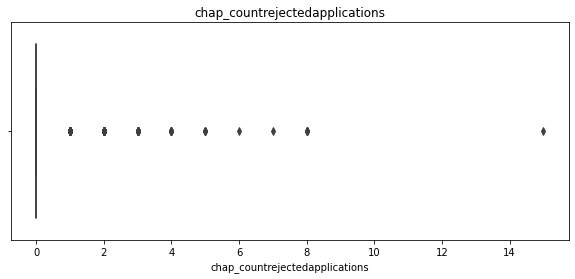

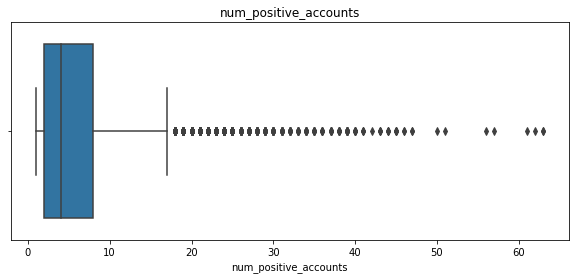

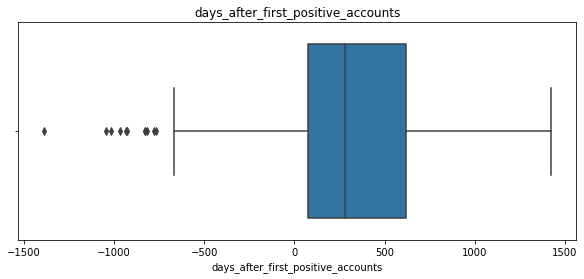

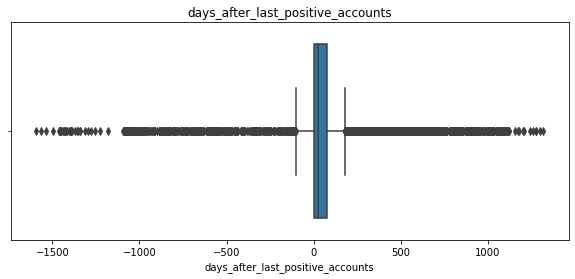

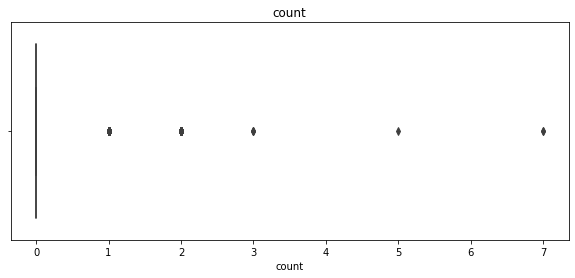

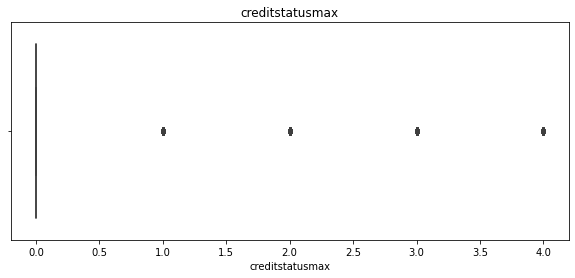

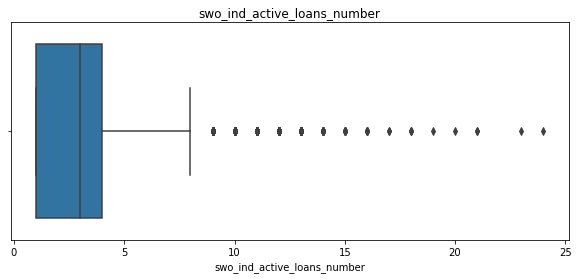

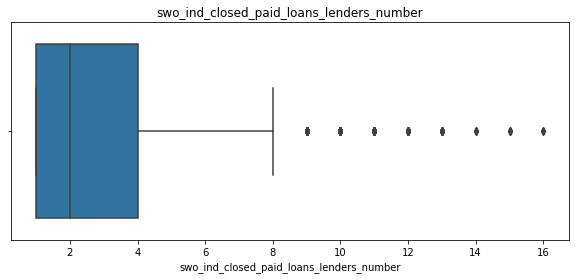

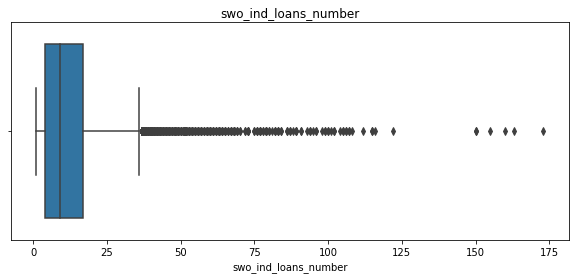

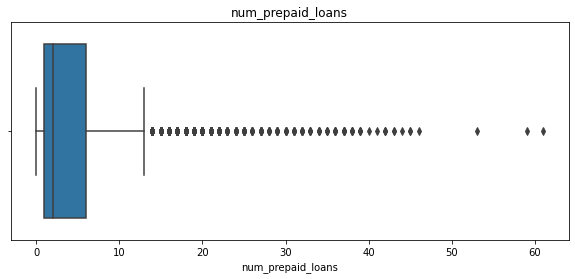

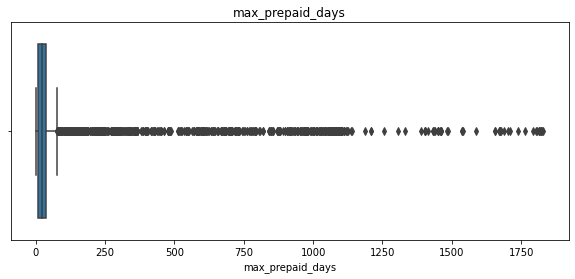

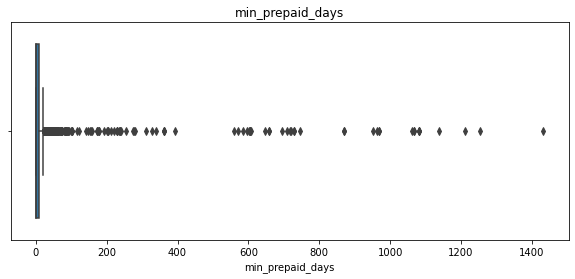

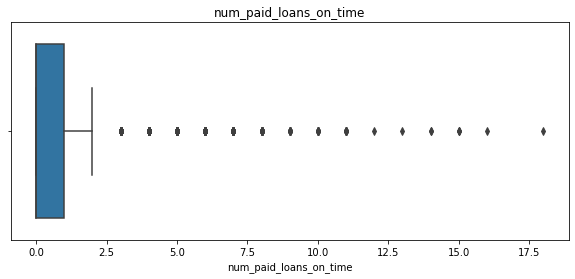

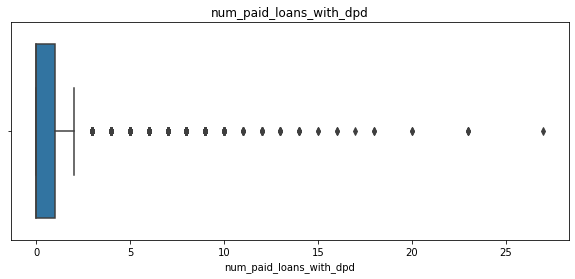

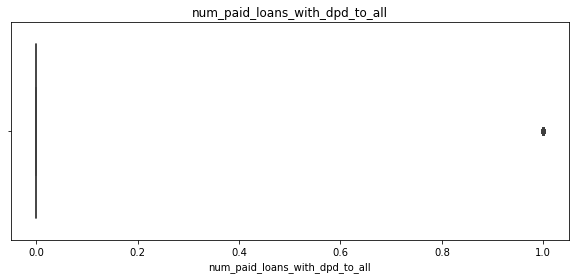

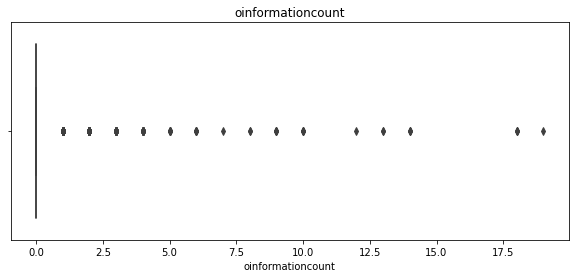

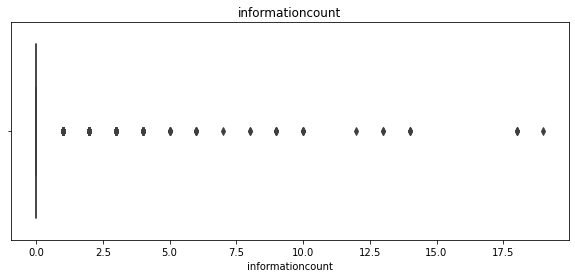

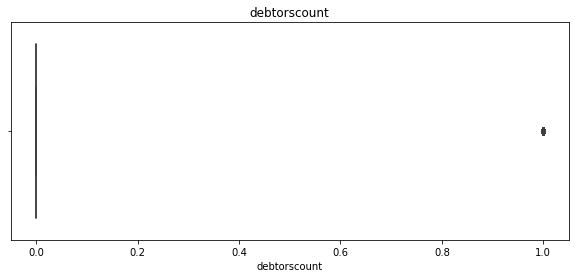

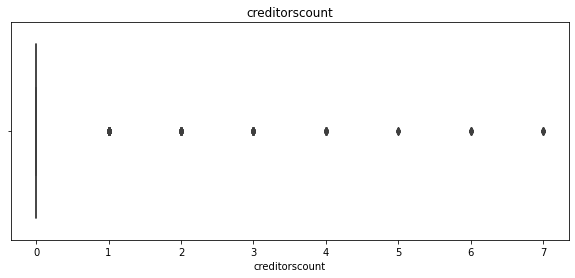

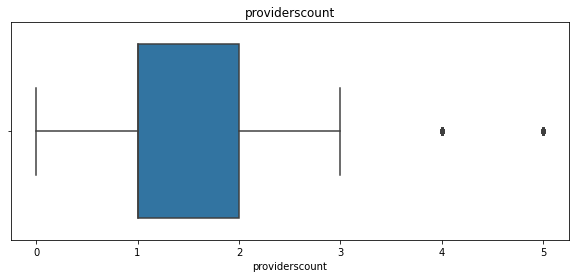

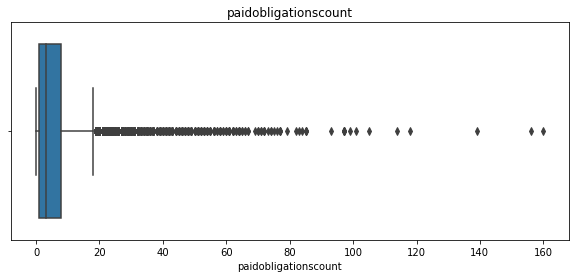

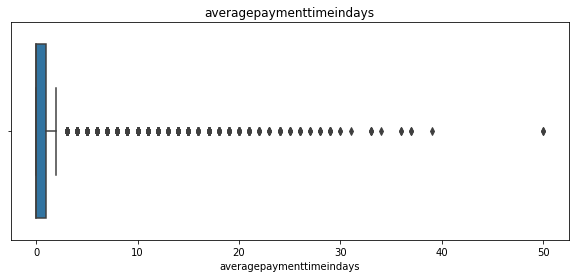

In [14]:
# Defining new "numerical_data" variable only to be used with our boxplots  
numerical_data = train[num_miss_var]

for missing_variable in numerical_data:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=numerical_data[missing_variable])
    plt.title(missing_variable)
    plt.show()

As we can see in the presented variables, there are numerous outliers, which prevents us from using the mean. In such a case, I decide to replace the missing values in each of the variables with their mode. The mode also replaces the textual values.

In [15]:
# Replace the missing values for numerical columns with mode
for column in num_miss_var:
    train[column] = train[column].fillna(train[column].mode()[0])
    
# Replace the missing values for textual columns with mode
for column in text_miss_var:
    train[column] = train[column].fillna(train[column].mode()[0])

Since our data has been cleansed of missing values, I separate the TARGET variable from the rest of our training dataset.

In [18]:
# Defining "model_ds" as our modelling dataset
model_ds = train.drop(['TARGET'], axis=1)
# Defining "model_tar" as a dataset which stores our TARGET VARIABLE
model_tar = train['TARGET']

We are at a point where we have managed to deal with missing data. However, we are not yet ready to move on to modeling. If we look at all our variables, we will see that a large part of them are so-called categorical variables. Such variables are characterized by the fact that we often cannot represent them with binary values.

In [20]:
# Establishing which variables are "object" data type
object_columns = model_ds.select_dtypes(include=['object']).columns.tolist()
len(object_columns)

37

In [21]:
model_ds[object_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   loan_date_created                 10000 non-null  object
 1   applicationprice                  10000 non-null  object
 2   avgbetweenapplications            10000 non-null  object
 3   avgbetweenapprovedapplications    10000 non-null  object
 4   avgextensions                     10000 non-null  object
 5   avgloanterm                       10000 non-null  object
 6   income_charge                     10000 non-null  object
 7   onavgdpd                          10000 non-null  object
 8   sum_positive_accounts             10000 non-null  object
 9   amounttotal                       10000 non-null  object
 10  amounttotalopen                   10000 non-null  object
 11  citysize                          10000 non-null  object
 12  companiesinhouse   

Firstly, we need to deal with the 'loan_date_created' variable. I decide to transform it in the following way.

In [22]:
# Converting to datetime datatype
model_ds['loan_date_created'] = pd.to_datetime(model_ds['loan_date_created'])

# Converting to int datatype with use of unix timestamp
model_ds['loan_date_created'] = model_ds['loan_date_created'].apply(lambda x: int(x.timestamp()))

In [23]:
# Here, we are converting all "object" type variables into int64
for column in model_ds[object_columns]:
    if model_ds[column].dtype == np.object or model_ds[column].dtype == 'O':
        try:
            model_ds[column] = model_ds[column].str.replace(',', '').astype('int64')
        except ValueError:
            print(f"Column {column} can't be converted to 'int64'")

/var/folders/gr/v5rg5xg16930jrqr4ctbsrq00000gn/T/ipykernel_82134/1961553628.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if model_ds[column].dtype == np.object or model_ds[column].dtype == 'O':


Column citysize can't be converted to 'int64'
Column companiesinhouse can't be converted to 'int64'
Column decision can't be converted to 'int64'
Column gender can't be converted to 'int64'
Column householdsize can't be converted to 'int64'
Column housesize can't be converted to 'int64'
Column legalform can't be converted to 'int64'
Column value can't be converted to 'int64'
Column housetype can't be converted to 'int64'
Column identificationtype can't be converted to 'int64'
Column score_partialdecision can't be converted to 'int64'


In [24]:
model_ds[object_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   loan_date_created                 10000 non-null  int64 
 1   applicationprice                  10000 non-null  int64 
 2   avgbetweenapplications            10000 non-null  int64 
 3   avgbetweenapprovedapplications    10000 non-null  int64 
 4   avgextensions                     10000 non-null  int64 
 5   avgloanterm                       10000 non-null  int64 
 6   income_charge                     10000 non-null  int64 
 7   onavgdpd                          10000 non-null  int64 
 8   sum_positive_accounts             10000 non-null  int64 
 9   amounttotal                       10000 non-null  int64 
 10  amounttotalopen                   10000 non-null  int64 
 11  citysize                          10000 non-null  object
 12  companiesinhouse   

All the "object" type variables that we can observe above are so-called categorical variables. At this moment, I decide to perform Label Encoding on them using the LabelEncoder object from sklearn.

In [25]:
#LabelEncoder importing and creation of le object 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [26]:
# Creation of a new variable, which is going to store all object dtype variables left
categorical_var = ['citysize', 'companiesinhouse', 'decision', 'gender', 'householdsize', 'housesize', 'legalform', 'value', 'housetype', 'identificationtype', 'score_partialdecision']

In [28]:
model_ds[categorical_var].head()

,citysize,companiesinhouse,decision,gender,householdsize,housesize,legalform,value,housetype,identificationtype,score_partialdecision
0,XXL,M,GREEN,MALE,UNKNOWN,L,PERSON,ADULT,SHARED_USAGE,IDENTITY_IN_UNIVERSE,GREEN
1,S,UNKNOWN,GREEN,MALE,M,S,PERSON,ADULT,UNKNOWN,IDENTITY_IN_UNIVERSE,RED
2,L,L,GREEN,MALE,S,L,PERSON,UNKNOWN,SHARED_USAGE,IDENTITY_IN_HOUSE,GREEN
3,XXL,L,GREEN,FEMALE,UNKNOWN,XL,PERSON,ADULT,SHARED_USAGE,IDENTITY_IN_CITY,GREEN
4,S,UNKNOWN,GREEN,MALE,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,PRIVATE_ONLY,IDENTITY_IN_UNIVERSE,GREEN


In [31]:
# Label encoding
for column in model_ds[categorical_var]:
    le = LabelEncoder()
    model_ds[column] = le.fit_transform(model_ds[column])

In [32]:
model_ds[categorical_var].head()

,citysize,companiesinhouse,decision,gender,householdsize,housesize,legalform,value,housetype,identificationtype,score_partialdecision
0,4,1,0,1,3,0,0,0,3,3,0
1,2,3,0,1,1,2,0,0,4,3,1
2,0,0,0,1,2,0,0,1,3,1,0
3,4,0,0,0,3,4,0,0,3,0,0
4,2,3,0,1,3,3,1,1,1,3,0


In [33]:
# Our trainig dataset 
model_ds.head()

,application_id,loan_date_created,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,...,oinformationcount,informationcount,debtorscount,creditorscount,amount,providerscount,paidobligationscount,averagepaiddebt,averagepaymenttimeindays,sumpaiddebt
0,4275,1606608000,0,2500,40211,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0
1,9635,1613520000,0,600,0,0,0,0,30,1,...,0.0,0.0,0.0,0.0,0,1.0,2.0,1500,1.0,159
2,5383,1607904000,0,500,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0,2.0,3.0,46667,0.0,68
3,442,1589068800,0,500,0,1,0,0,0,2,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0
4,5070,1602460800,0,300,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0,2.0,18.0,45915,0.0,3286


Our training dataset has already undergone proper analysis and appropriate modifications. We will now move on to importing the open-source library XGBoost and installing the necessary packages.

In [36]:
# Checking the proportions of individuals who fell into DEFAULT compared to those who have repaid the loan.
train.groupby(['TARGET']).size()/train.shape[0] * 100

TARGET
0    77.27
1    22.73
dtype: float64

# Importing the open-source library XGBoost and defining all the necessary variables needed to conduct the training

In [37]:
pip install Xgboost

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [38]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [39]:
model = XGBClassifier(tree_method = 'exact')

In [40]:
model.fit(model_ds, model_tar.values.ravel())
tar_pred = model.predict(model_ds)

In [41]:
# Checking accuracy of our model, naturally it is going to be high, because I haven't rejected to many variables
accuracy_score(model_tar, tar_pred)

0.9905

Text(33.0, 0.5, 'Actuals')

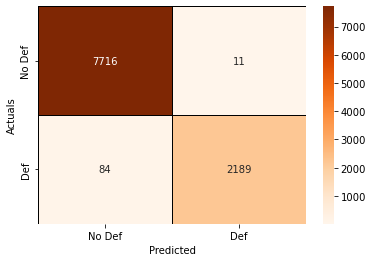

In [42]:
cm = confusion_matrix(model_tar, tar_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap = 'Oranges', linewidths = 0.5, linecolor='Black')
plt.xticks(np.arange(2)+.5, ['No Def','Def'])
plt.yticks(np.arange(2)+.5, ['No Def','Def'])
plt.xlabel('Predicted')
plt.ylabel('Actuals')

# Analysis and modification of testing dataset

When our model is already trained on the training data, it is naturally time for us to deal with the test data. During the analysis and processing of the training data, due to a large amount of missing data, I decided to remove eight variables from our dataset. Before starting modeling on our test data (often called validation data), I must bring our test data to the exact same form as our training data currently is.

In [90]:
# Loading test data
test = pd.read_csv('/Users/michalpoleszczuk/Desktop/data_DS_HW_test.csv', sep=';')

In [91]:
# Checking for missing values
test.isnull().sum()

application_id               0
loan_date_created            0
activeloan_coalt             0
applicationamount            0
applicationprice             0
                            ..
providerscount              13
paidobligationscount        13
averagepaiddebt             13
averagepaymenttimeindays    13
sumpaiddebt                 13
Length: 234, dtype: int64

In [92]:
# I am checking whether dropped variabels are present in out test dataset
# If print function does not execute, it means that all of those variables are present in test DS

for column in dropped_variables:
    if column not in test.columns:
        print(f"Column not found in DataFrame: {column}")

In [93]:
# Dropping so-called dropped_variables from our test DS
test = test.drop(columns = dropped_variables)

In [94]:
text_columns_test = list()
numerical_columns_test = list()

for column in test.columns:
    # Check if the data type of the column is object
    if test[column].dtype == 'object':
        text_columns_test.append(column)
    else:
        # Assuming all non-object types are numerical
        numerical_columns_test.append(column)

In [95]:
text_miss_var_test = list()
num_miss_var_test = list()

# Appending missing numerical variable names in test DS
for column in numerical_columns_test:
    if column in missing_columns:
        num_miss_var_test.append(column)
        
# Printing missing textual variable names in test DS
for column in text_columns_test:
    if column in missing_columns:
        text_miss_var_test.append(column)

In [96]:
#Replace the missing values for numerical columns with mode
for column in num_miss_var_test:
    test[column] = test[column].fillna(test[column].mode()[0])
    
#Replace the missing values for textual columns with mode
for column in text_miss_var_test:
    test[column] = test[column].fillna(test[column].mode()[0])

In [97]:
# All "object" dtype variables will have to be changed before proceeding
object_columns_test = test.select_dtypes(include=['object']).columns.tolist()

In [98]:
test[object_columns_test].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4646 entries, 0 to 4645
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   loan_date_created                 4646 non-null   object
 1   applicationprice                  4646 non-null   object
 2   avgbetweenapplications            4646 non-null   object
 3   avgbetweenapprovedapplications    4646 non-null   object
 4   avgextensions                     4646 non-null   object
 5   avgloanterm                       4646 non-null   object
 6   income_charge                     4646 non-null   object
 7   onavgdpd                          4646 non-null   object
 8   sum_positive_accounts             4646 non-null   object
 9   amounttotal                       4646 non-null   object
 10  amounttotalopen                   4646 non-null   object
 11  citysize                          4646 non-null   object
 12  companiesinhouse    

In [99]:
# Converting to datetime datatype
test['loan_date_created'] = pd.to_datetime(test['loan_date_created'])
# Converting to int datatype with use of unix timestamp
test['loan_date_created'] = test['loan_date_created'].apply(lambda x: int(x.timestamp()))

In [100]:
# Here, we are converting all "object" type variables into int64
for column in test[object_columns_test]:
    if test[column].dtype == np.object or test[column].dtype == 'O':
        try:
            test[column] = test[column].str.replace(',', '').astype('int64')
        except ValueError:
            print(f"Column {column} can't be converted to 'int64'")

Column onavgdpd can't be converted to 'int64'
Column citysize can't be converted to 'int64'
Column companiesinhouse can't be converted to 'int64'
Column decision can't be converted to 'int64'
Column gender can't be converted to 'int64'
Column householdsize can't be converted to 'int64'
Column housesize can't be converted to 'int64'
Column legalform can't be converted to 'int64'
Column value can't be converted to 'int64'
Column housetype can't be converted to 'int64'
Column identificationtype can't be converted to 'int64'
Column score_partialdecision can't be converted to 'int64'


/var/folders/gr/v5rg5xg16930jrqr4ctbsrq00000gn/T/ipykernel_82134/522355947.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if test[column].dtype == np.object or test[column].dtype == 'O':


In [101]:
# Due to the problem that occurs with one variable, I decide to manually change it to the float datatype.
test['onavgdpd'] = test['onavgdpd'].str.replace(',', '.')
test['onavgdpd'] = test['onavgdpd'].astype(float)

In [102]:
categorical_var_test = ['citysize', 'companiesinhouse', 'decision', 'gender', 'householdsize', 'housesize', 'legalform', 'value', 'housetype', 'identificationtype', 'score_partialdecision']

In [103]:
# Label encoding
for column in test[categorical_var_test]:
    le_test = LabelEncoder()
    test[column] = le_test.fit_transform(test[column])

In [104]:
test.head()

,application_id,loan_date_created,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,...,oinformationcount,informationcount,debtorscount,creditorscount,amount,providerscount,paidobligationscount,averagepaiddebt,averagepaymenttimeindays,sumpaiddebt
0,223,1581292800,1,1000,0,0,0,0,30,1,...,0.0,0.0,0.0,0.0,0,2.0,6.0,285736,0.0,1714415
1,20671,1614729600,0,600,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0,1.0,4.0,184298,6.0,737191
2,2218,1586563200,0,200,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0,2.0,12.0,12846,0.0,1541521
3,19196,1627862400,0,3000,36191,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0,2.0,10.0,128699,2.0,1286988
4,13088,1603756800,0,2500,40211,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0,2.0,5.0,5358,9.0,267902


We have reached a point where our training dataset and test dataset have been brought to the same form (in terms of variables). To avoid bias, I replaced the missing values in our test set using the same methods as in the case of the training set. The last thing left for us is to determine the modeling for the target variable. I decide to present its final form as an array.

# Prediction of the target variable

In [105]:
test_predictions = model.predict(test)
test_predictions

array([0, 1, 0, ..., 0, 0, 1])